## Vehicle Detection pipeline

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob

import time


In [2]:
car_list=[]
notcar_list=[]

cars = glob.glob('TrainingData\\vehicles\\*\\*.png')
for car in cars:
    car_list.append(car)
    
notcars = glob.glob('TrainingData\\non-vehicles\\*\\*.png')
for notcar in notcars:
    notcar_list.append(notcar)

print('Size of car images list: ', len(car_list))
print('Size of notcar images list: ', len(notcar_list))

Size of car images list:  8792
Size of notcar images list:  8968


### Lets use one of the images for our initial explorations

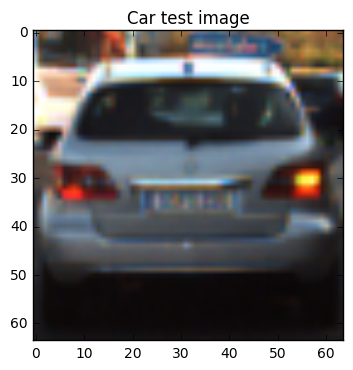

In [3]:
test_idx = np.random.randint(0,len(car_list))
test_file = car_list[test_idx]

test_img = plt.imread(test_file)

# Scale the imagae appropriately
test_img = (test_img * 255).astype(np.uint8)

# print(test_img)

plt.imshow(test_img), plt.title('Car test image')
plt.show()



In [4]:
def color_conversion(image, color_space='RGB'):

    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    return feature_image


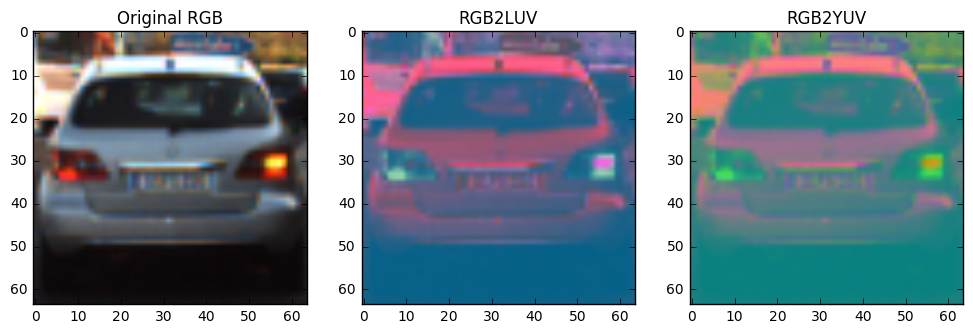

In [5]:
# Test the convert_color function
img2 = np.copy(test_img)

fig = plt.figure(figsize=(12,4))
plt.subplot(131), plt.title('Original RGB')
plt.imshow(img2)

plt.subplot(132), plt.title('RGB2LUV')
plt.imshow(color_conversion(img2,'LUV'))

plt.subplot(133), plt.title('RGB2YUV')
plt.imshow(color_conversion(img2,'YUV'))

plt.show()

In [20]:
def color_histogram(img,nbins=32, bins_range=(0,256)  ):
    
    # np.histogram returns histogram and bin_edges. 
    # Edges will be 1 greater than bins
    new = np.copy(img)
    r_hist = np.histogram(new[:,:,0],nbins,bins_range)
    g_hist = np.histogram(new[:,:,1],nbins,bins_range)
    b_hist = np.histogram(new[:,:,2],nbins,bins_range)
    
    # The histogram values are the feature vector
    feature_vec = np.concatenate((r_hist[0],g_hist[0],b_hist[0]))

    return feature_vec



In [21]:
hist_bins = 32
hist_range = (0,256)

hist_features size:  96


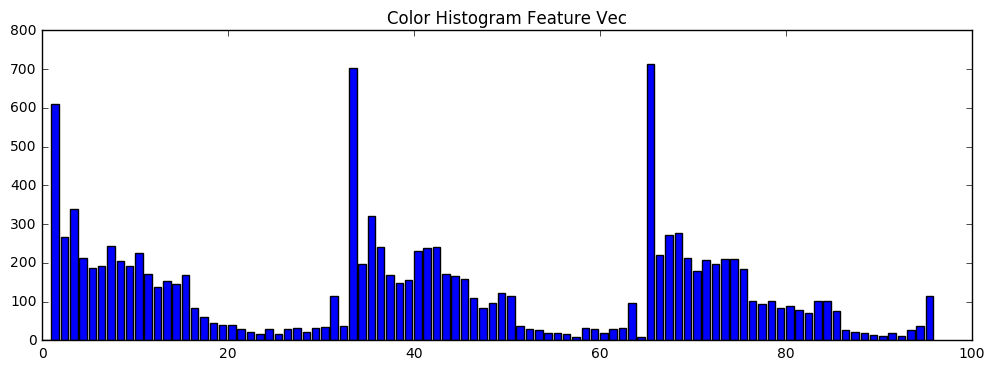

In [22]:
# Test the color_histogram function
img2 = np.copy(test_img)

hist_features = color_histogram(img2,hist_bins,hist_range) 
print('hist_features size: ', len(hist_features))

fig = plt.figure(figsize=(12,4))
plt.bar(range(len(hist_features)),hist_features)
plt.title('Color Histogram Feature Vec')
fig.savefig('./output_images/1_color_hist_feature_vec.png',bbox_inches = 'tight')
plt.show()


In [23]:
#%%
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

In [24]:
spatial_size = (32,32)

Spatial_features size:  3072


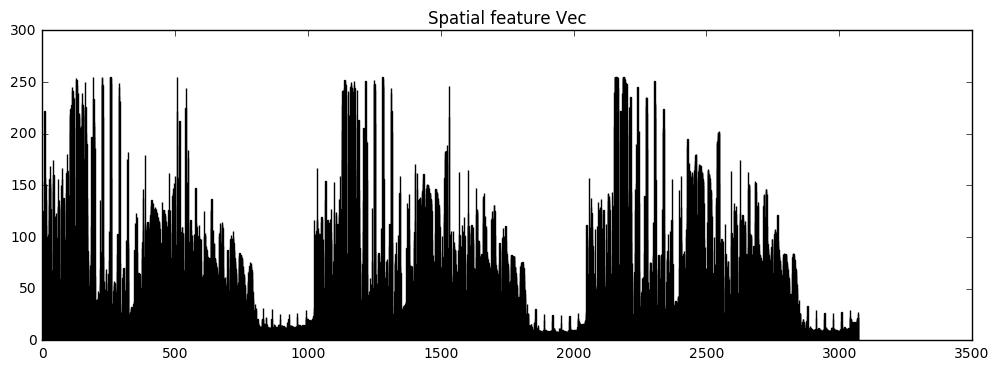

In [25]:
# Test the bin_spatial function
img2 = np.copy(test_img)

spatial_features = bin_spatial(img2,spatial_size) 
print('Spatial_features size: ', len(spatial_features))
fig = plt.figure(figsize=(12,4))
plt.bar(range(len(spatial_features)),spatial_features)
plt.title('Spatial feature Vec')

fig.savefig('./output_images/2_spatial_vect.png',bbox_inches = 'tight')
plt.show()


In [26]:
# Define a function to return HOG features and visualization

from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
                
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        
        return features

    

In [27]:
orient = 12
pix_per_cell = 8
cell_per_block = 2
vis = True
feature_vec = True


hog_features size:  7056


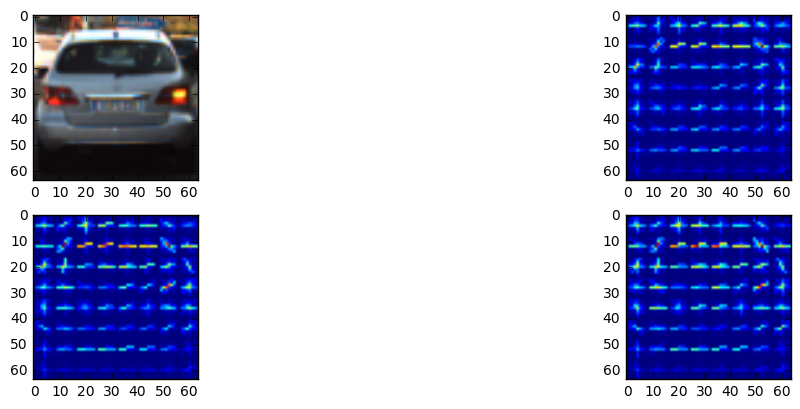

In [28]:
# Test the HOG features function
# test_img2 = plt.imread('./test_images/test1.jpg')
# test_img2 = cv2.resize(test_img2[400:550,1000:],(64,64))
# img2 = np.copy(test_img2)

img2 = np.copy(test_img)

fig = plt.figure(figsize=(12,4))
plt.subplot(221), plt.imshow(img2)
plt.tight_layout()

features_hog = []
for i in range(3):
    hog_features,hog_image = get_hog_features(img2[:,:,i],orient=orient,
                                pix_per_cell=pix_per_cell,
                                cell_per_block= cell_per_block,
                                vis= vis ,feature_vec = feature_vec)
    
    features_hog.extend(hog_features)
    plt.subplot(222+i)
    plt.imshow(hog_image)

    
# plt.suptitle('HOG feature vector for RGB image')
print('hog_features size: ', len(features_hog))

fig.savefig('./output_images/3_hog_feature_vec.png',bbox_inches = 'tight')

plt.show()


In [29]:
# img2 = np.copy(test_img)
# winSize = (64,64)
# blockSize = (16,16)
# blockStride = (8,8)
# cellSize = (8,8)
# nbins = 12
# # derivAperture = 1
# # winSigma = 4.
# # histogramNormType = 0
# # L2HysThreshold = 2.0000000000000001e-01
# # gammaCorrection = 0
# # nlevels = 64
# hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)

# # hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
# #                         histogramNormType,L2HysThreshold,gammaCorrection,nlevels)

# #compute(img[, winStride[, padding[, locations]]]) -> descriptors
# winStride = (8,8)
# padding = (8,8)
# locations = ((10,20),)
# hist = hog.compute(img2,winStride,padding,locations)


In [30]:
print(np.amax(hist))
print(np.amax(features_hog))
print(len(hist))



# plt.show()

0.0
0.300125909429
2352


In [31]:
# Define a HOG feature function that can be used on not only gray scale but all channels:
# In this case, hog_image isnt returned. Call fcn with vis= False
def get_all_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True, hog_channel=0):
                
    # Call with two outputs if vis==True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(img.shape[2]):
            hog_features.extend(hog(img[:,:,channel], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=False, feature_vector=feature_vec)) 
    else:
                                
        hog_features = hog(img[:,:,hog_channel], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        
    return hog_features


In [32]:
# Let's combine all the above so that we have 1 common function for extracting features from an image. 

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of image files

def single_img_features(img, color_space='RGB', spatial_size=(32,32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    

    #1) Define an empty list to receive features
    img_features = []

    #2) Apply color conversion if other than 'RGB'
    feature_image = color_conversion(img, color_space=color_space)
        
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_histogram(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        hog_features = get_all_hog_features(feature_image,orient=orient,
                                    pix_per_cell=pix_per_cell,
                                    cell_per_block= cell_per_block,
                                    vis= False ,feature_vec = True, hog_channel=hog_channel)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

    

In [33]:
# Test the single image features function
img2 = np.copy(test_img)
color_space = 'RGB'
hog_channel = 'ALL'

all_features =  single_img_features(img2, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=False, hist_feat=False, hog_feat=True)    


print('all_features  size: ', len(all_features))

all_features  size:  7056


## Extract Features for all images in the dataset. 

In [34]:
# Define a function to extract features from a list of images
# This function will use the single_image_feature function defined above. 

def extract_features(img_files, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for file in img_files:
        file_features = []
        
        # Read in each one by one
        img2 = plt.imread(file)
        file_features =  single_img_features(img2, color_space=color_space, spatial_size=spatial_size,
                                hist_bins=hist_bins, orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)    


        features.append(file_features)
        
    # Return list of feature vectors
    return features


In [35]:
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False# Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 700] # Min and max in y to search in slide_window()

# RGB, 9,8,2,ALL worked but had lot of false positives

# colorspace = 'YUV' 
# orient = 11 
# pix_per_cell = 16 
# cell_per_block = 2
# hog_channel = "ALL"
    
car_features = extract_features(car_list, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcar_list, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


print('Number of car images : ', len(car_features))
print('Car features vector size: ', len(car_features[0]))

print('Number of notcar images: ', len(notcar_features))
print('Notcar feature vector size: ', len(notcar_features[0]))

Number of car images :  8792
Car features vector size:  7056
Number of notcar images:  8968
Notcar feature vector size:  7056


## Create a Linear classifier for the data

### Normalize the data and create labels

In [36]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

# Stack the test data into m rows. m = len(car_list) + len(notcar_list) 
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Use the standard scalar to scale and zero mean the data.
# The stdscalar will take mean in a columnwise fashion. i.e each feature has its own mean and variance. 


# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))



In [37]:
# Split up data into randomized training and test sets
from sklearn.cross_validation import train_test_split

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))



Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7056
34.21 Seconds to train SVC...
Test Accuracy of SVC =  0.9634


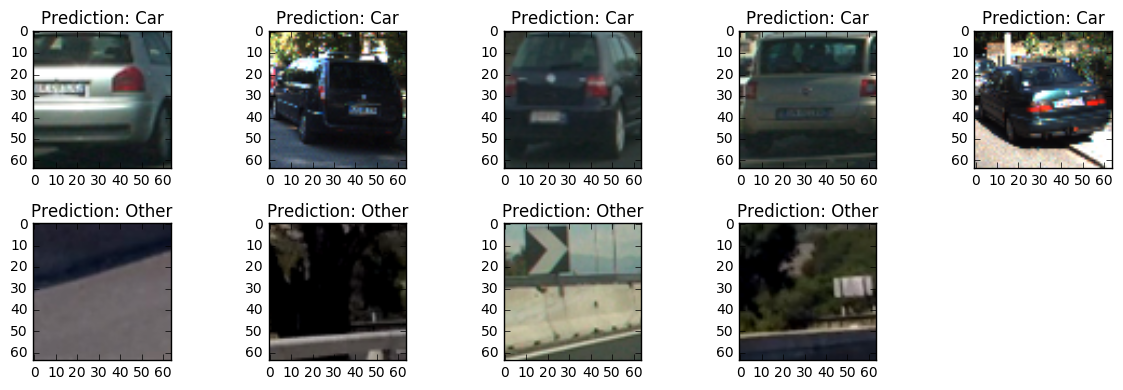

In [38]:
# Show a few images and their predictions images:
fig  = plt.figure(figsize=(12,4))
# plt.suptitle('Example SVC Predictions')
numImages = 5

for i in range(numImages):
    plotnum = 200 + 10*numImages+ 1+i
    plt.subplot(plotnum) # 2 rows, numImages cols, suplot number
    idx = np.random.randint(0,len(car_list)) 
    testimage = plt.imread(car_list[idx])
    
    plt.imshow(testimage)
    pred = svc.predict(scaled_X[idx].reshape(1,-1))
    
    if pred==1:
        out = 'Car'
    else:
        out = 'Other'

    plt.title('Prediction: {}'.format(out))

for j in range(numImages-1):
    plotnum = 200 + 10*numImages+ 1+numImages+j
    plt.subplot(plotnum)
    idx = np.random.randint(0,len(notcar_list)) 
    testimage = plt.imread(notcar_list[idx])
    
    plt.imshow(testimage)
    pred = svc.predict(scaled_X[len(car_list) + idx].reshape(1,-1))

    if pred==1:
        out = 'Car'
    else:
        out = 'Other'

    plt.title('Prediction: {}'.format(out))

plt.tight_layout()    

fig.savefig('./output_images/4_svc_prediction_outputs.png',bbox_inches = 'tight')

plt.show()


### Sliding windows


In [39]:
# Define a function that takes an image, start and stop positions in both x and y, 
# window size (x and y dimensions) and overlap fraction (for both x and y)
def create_sliding_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=[64, 64], xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    win_start = (x_start_stop[0],y_start_stop[0]) 
    win_stop =  (x_start_stop[1],y_start_stop[1])
        
    # Compute the span of the region to be searched    
    search_win_size = ( win_stop[0] - win_start[0] , win_stop[1] - win_start[1])
    
    # Compute the number of pixels per step in x/y
    overlap_px = (np.int(xy_overlap[0] * xy_window[0]),np.int(xy_overlap[1] * xy_window[1]))
    
    # Compute the number of windows in x/y
    n_win_x = np.int( ( ( search_win_size[0] - xy_window[0])/ overlap_px[0] )+ 1)
    n_win_y = np.int( ( ( search_win_size[1] - xy_window[1])/ overlap_px[1] ) + 1)
    
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for idy in range(n_win_y):
        for idx in range(n_win_x):
            current_window_topleft = ( (win_start[0]+ overlap_px[0]*idx) ,(win_start[1]+overlap_px[1]*idy) )
            current_window_bottomright = (current_window_topleft[0]+xy_window[0], 
                                          current_window_topleft[1]+xy_window[1])
            
            window_list.append((current_window_topleft,current_window_bottomright))            
            
    return window_list

In [40]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [41]:
# Define a function to search the windows for cars
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    orient=9,pix_per_cell=8,
                    cell_per_block=2,hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        
        #4) Extract features for that window using single_img_features()
        all_features =  single_img_features(test_img, color_space=color_space,
                                            spatial_size=spatial_size,hist_bins=hist_bins,
                                            orient=orient,pix_per_cell=pix_per_cell,
                                            cell_per_block=cell_per_block, hog_channel=hog_channel,
                                            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)    

        #5) Scale extracted features to be fed to classifier
#         test_features = scaler.transform(np.array(all_features).reshape(1, -1))
        test_features = scaler.transform(all_features.reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    


In [84]:
# Set up the paramters for creating varying sizes of sliding windows
list_xy_overlap  = [[0.9,0.9],[0.9,0.9],[0.9,0.9],[0.9,0.9]]
list_y_start_stop = [[400,500],[400,620],[400,620],[400,620]]
list_x_start_stop = [ [400,900],[200,None],[200,None],[200,None] ]
list_xy_window    =[ [48,48],[64, 64],[96,96],[128,128]]


Total number of sliding windows = 109 


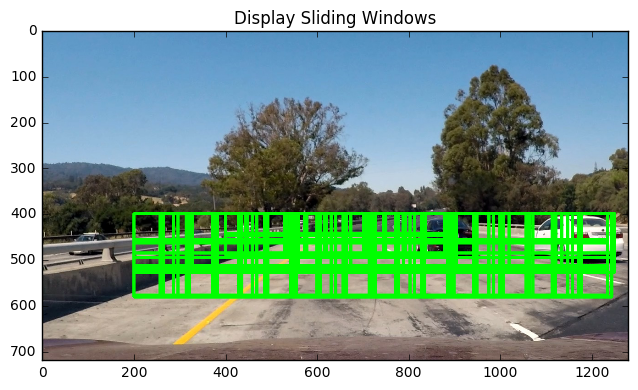

In [85]:
# Test the create_sliding_window function

image = plt.imread('./test_images/test1.jpg')
draw_image = np.copy(image)

windows=[]
for (xy_overlap,x_start_stop,y_start_stop,xy_window) in zip(list_xy_overlap,list_x_start_stop,list_y_start_stop,list_xy_window):

    windows.extend(create_sliding_window(draw_image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=xy_window, xy_overlap=xy_overlap) )


window_img = draw_boxes(draw_image, windows, color=(0, 255, 0), thick=6)                    


print('Total number of sliding windows = {} '.format(len(windows)))


fig = plt.figure(figsize=(12,4))

plt.title('Display Sliding Windows')

plt.imshow(window_img)
plt.tight_layout()    

fig.savefig('./output_images/5_sliding_windows.png',bbox_inches = 'tight')

plt.show()
    

Number of hot windows found:  6
Total number of windows    :  109


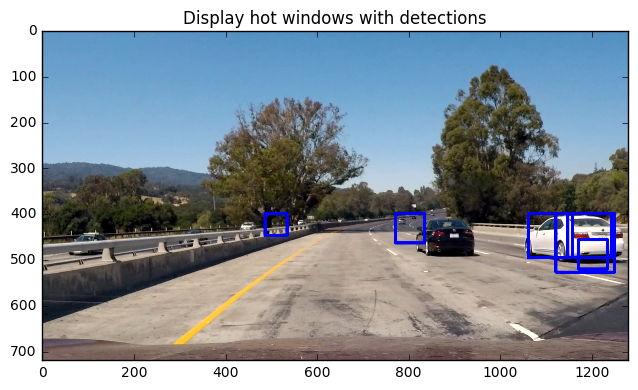

In [86]:
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

print('Number of hot windows found: ', len(hot_windows))
print('Total number of windows    : ', len(windows))

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

fig = plt.figure(figsize=(12,4))
plt.title('Display hot windows with detections')
plt.imshow(window_img)
plt.tight_layout()    

fig.savefig('./output_images/6_hot_windows.png',bbox_inches = 'tight')
plt.show()




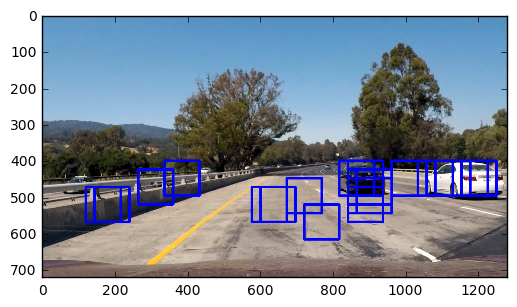

In [67]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    on_windows = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = color_conversion(img_tosearch, 'RGB')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block,vis=False, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block,vis=False, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block,vis=False, feature_vec=False)
    

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          

            # Scale features and make a prediction
            test_features = X_scaler.transform(hog_features.reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
                on_windows.append (((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))

    return draw_img, on_windows
    
ystart = 400
ystop = 656
scale = 1.5
    
out_img,hot_windows = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)
plt.show()
# print(on_windows)

## Create a heatmap based on the previous image

In [68]:
def add_heat(heatmap,bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap
    


In [69]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [70]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


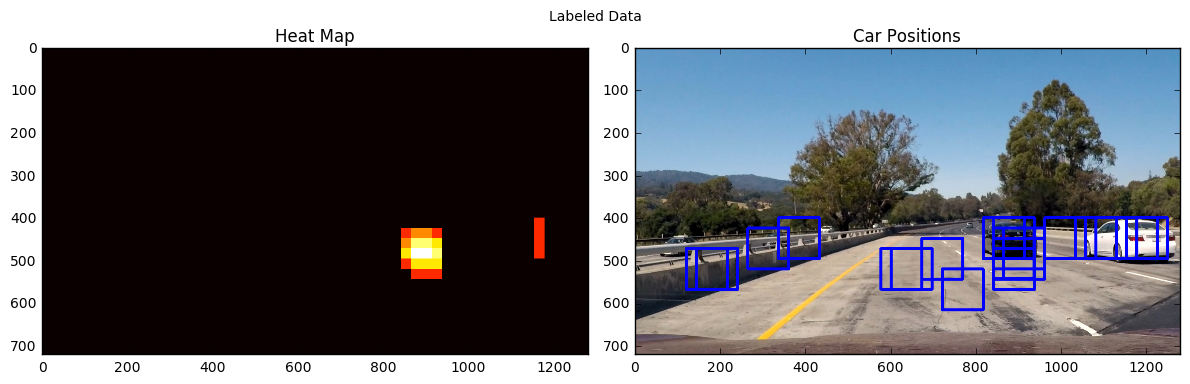

In [73]:
from scipy.ndimage.measurements import label

image = out_img
# Create empty array for the heat
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each hot window
add_heat(heat,hot_windows)

#Threshold the heat 
heat = apply_threshold(heat, 2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)

# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize=(12,4))
plt.suptitle('Labeled Data')

plt.subplot(121)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.subplot(122)
plt.imshow(draw_img)
plt.title('Car Positions')
fig.tight_layout()

fig.savefig('./output_images/7_label_fcn_data.png',bbox_inches = 'tight')
plt.show()

# print(labels[1], 'cars found')


### Movie Maker

In [74]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

all_bbox_list = []

In [79]:
def process_image(image):
    
    global all_bbox_list
    draw_image = np.copy(image)

#     windows=[]
    
#     #1) Create the desired windows:
#     for (xy_overlap,x_start_stop,y_start_stop,xy_window) in zip(list_xy_overlap,list_x_start_stop,list_y_start_stop,list_xy_window):

#         windows.extend(create_sliding_window(draw_image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
#                         xy_window=xy_window, xy_overlap=xy_overlap) )

#     #2) Search for the hot windows with detections.
#     hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
#                         spatial_size=spatial_size, hist_bins=hist_bins, 
#                         orient=orient, pix_per_cell=pix_per_cell, 
#                         cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                         hist_feat=hist_feat, hog_feat=hog_feat)                       

    out_img,hot_windows = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    #3) add the hot windows to the list of all boxes.
    all_bbox_list.append(hot_windows)
    
    #4) Take the last 20 frames for averaging the hot windows
    numFrames = 20
    if len(all_bbox_list)>numFrames :
        all_bbox_list = all_bbox_list[-numFrames:]
    
    #5) Create the heat maps for the bboxes
    # Create empty array for the heat
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    #Add heat to each hot window
    for boxes_each_frame in all_bbox_list:
        add_heat(heat,boxes_each_frame)

    #6) Threshold the heatmap
    heat = apply_threshold(heat, np.int(40))

    #7) Clip the heatmap to 255. This will be used for displaying as an image    
    heatmap = np.clip(heat, 0, 255)

    #8) Find final boxes from heatmap using label function
    labels = label(heatmap)

    #9) Draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    return draw_img

In [80]:
video_output = './Videos/out_test_video.mp4'
clip1 = VideoFileClip("./Videos/test_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./Videos/out_test_video.mp4
[MoviePy] Writing video ./Videos/out_test_video.mp4


 97%|█████████▋| 38/39 [00:08<00:00,  4.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./Videos/out_test_video.mp4 

Wall time: 9.76 s
